# Explorary Data Analysis with Clustering

## Data Loading & Processing
- Input: voting matrix V, distance matrix D
- Normalize: V_norm(i, j) = V(i, j) / sum_{k=1 to n} V(i, k), D_norm (i, j) = (D(i, j) - min(D)) / max(D) - min(D)

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
country_info_path = "data/country_info_aligned.csv"
distances_path = "data/distances.csv"
votes_path = "data/votes.csv"

# create voting matrix V and distance matrix D 

# distance matrix D
# organize in order according to country_info file (left -> right, up -> down)
country_info_df = pd.read_csv(country_info_path)
map_name_to_idx, map_code_to_idx, map_capital_to_idx = {}, {}, {}
country_info_array = np.array(country_info_df) 
country_info_list = country_info_array.tolist()  
for idx, country in enumerate(country_info_list):
    map_name_to_idx[country[0]], map_code_to_idx[country[1]], map_capital_to_idx[country[2]]  = idx, idx, idx


distances_df = pd.read_csv(distances_path)
distances_array = np.array(distances_df)
distances_list = distances_array[:, 1:].tolist()
old_order = distances_array[:, 0]
map_old_order_to_idx = {capital:idx for idx, capital in enumerate(old_order)}
country_num = len(old_order)
# (i, j) -> (i', j') in old_order -> distance(i', j') in distances_list
distances_list_in_new_order = [[
    distances_list[map_old_order_to_idx[country_info_list[j][2]]][map_old_order_to_idx[country_info_list[i][2]]] 
    for j in range(country_num)] for i in range(country_num)]
distance_matrix = distances_list_in_new_order

# normalize
def normalize_2d_list(matrix):
    normalized_matrix = []
    for row in matrix:
        row_sum = sum(row)
        if row_sum == 0:
            normalized_matrix.append([0] * len(row))
        else:
            normalized_row = [element / row_sum for element in row]
            normalized_matrix.append(normalized_row)
    return normalized_matrix

distance_matrix_norm = normalize_2d_list(distance_matrix)

In [110]:
# voting matrix V
# only consider 2023, final and total points in this sample
# omit other countries wld
votes_df = pd.read_csv(votes_path)
votes_array = np.array(votes_df) 
votes_list = votes_array.tolist()  

votes_matrix = [[0 for i in range(country_num)] for j in range(country_num)]

for vote in votes_list:
    if vote[0] != 2023 or vote[1] != 'final':
        continue
    from_country_code, to_country_code, tatol_points = vote[2], vote[3], vote[-3]
    if from_country_code == 'wld' or to_country_code == 'wld':
        continue
    votes_matrix[map_code_to_idx[from_country_code]][map_code_to_idx[to_country_code]] += tatol_points

# normalize
vote_matrix_norm = normalize_2d_list(votes_matrix)

## Clustering
- clustering by countries
Each row of D and V can be seen as a country.  cluster by rows...
- clustering by country-country pairs
Each element of D and V can be seen as a country-country pair.  cluster by elements...

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def cluster_by_countries(V, D, num_clusters):
    """
    Cluster the rows of D (country) using k-means and visualize D and V based on clustering results.

    Parameters:
        V (list of list of floats): 2D list where each row corresponds to num*num dimensions.
        D (list of list of floats): 2D list where each row is to be clustered.
        num_clusters (int): Number of clusters to use in k-means.

    Returns:
        None
    """
    V = np.array(V)
    D = np.array(D)

    # Perform k-means clustering on D
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(D)

    # Visualize D
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for cluster in range(num_clusters):
        cluster_points = D[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('Visualization of D')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    # Visualize V
    plt.subplot(1, 2, 2)
    for cluster in range(num_clusters):
        cluster_points = V[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.title('Visualization of V')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

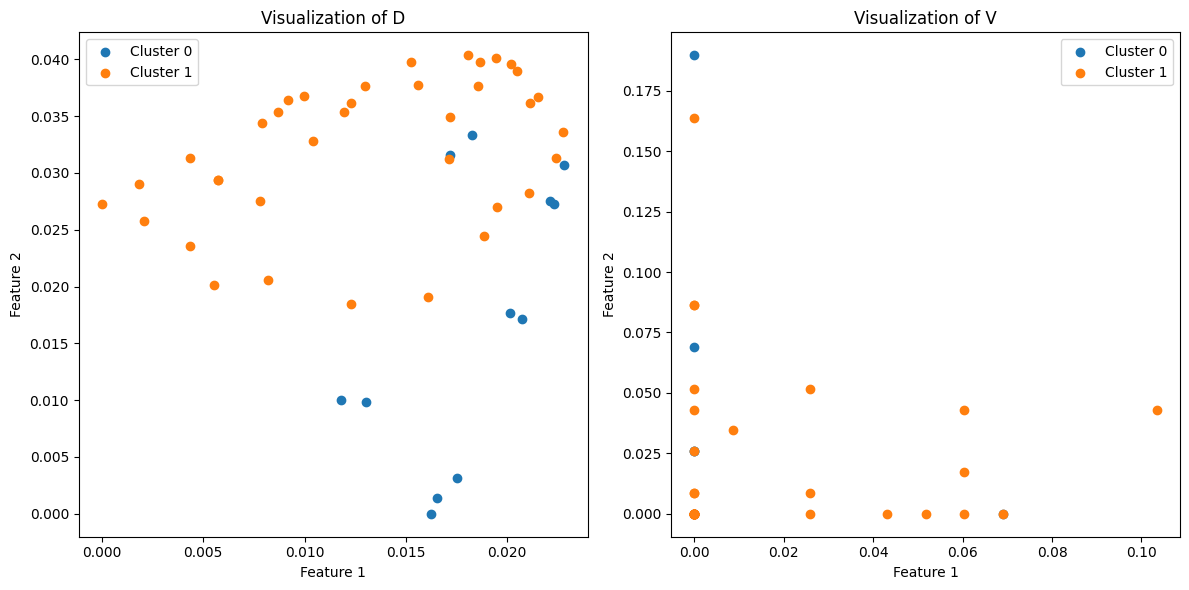

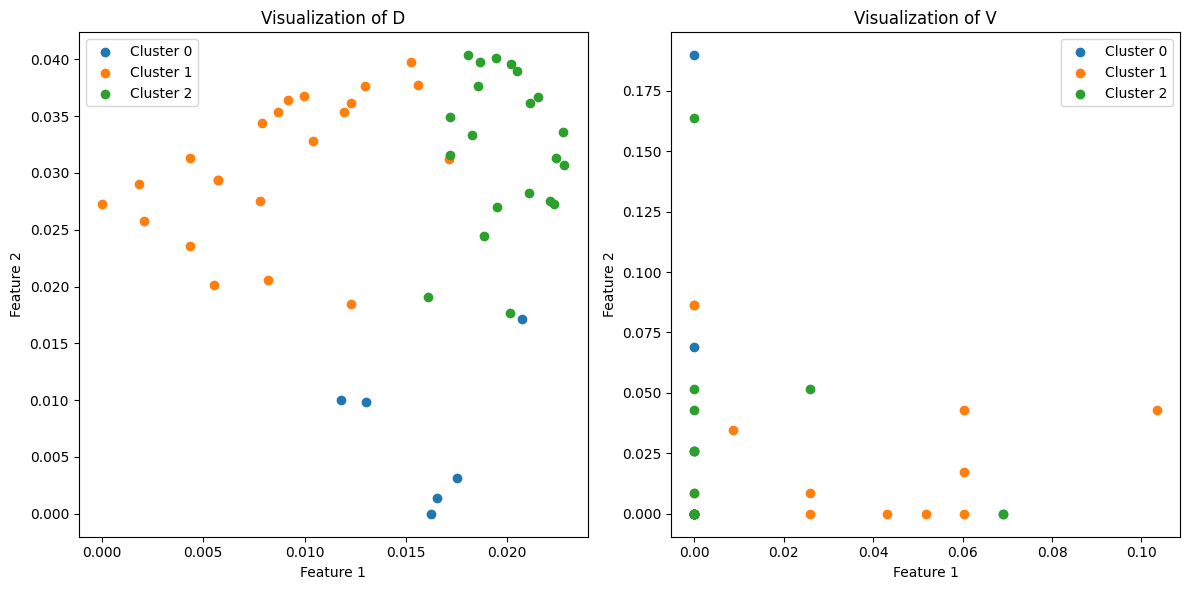

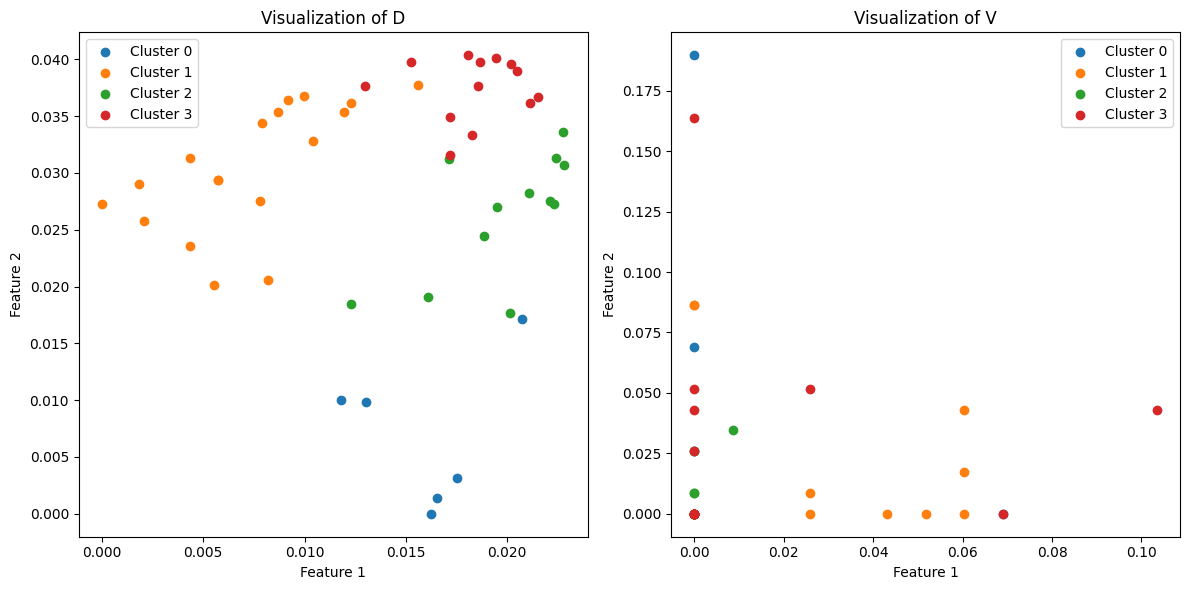

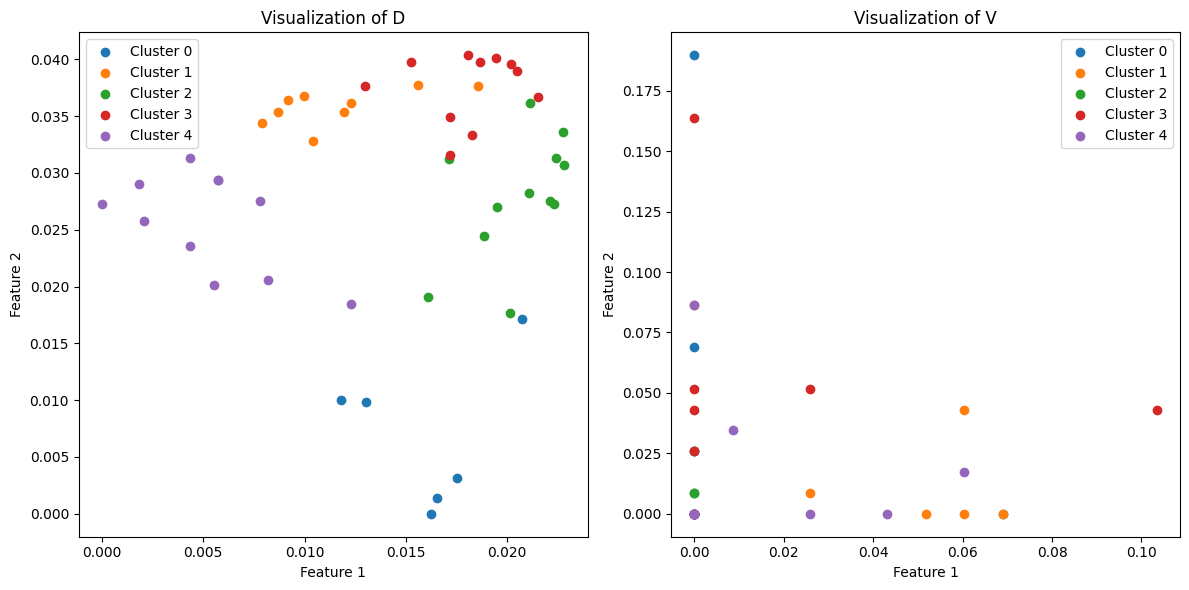

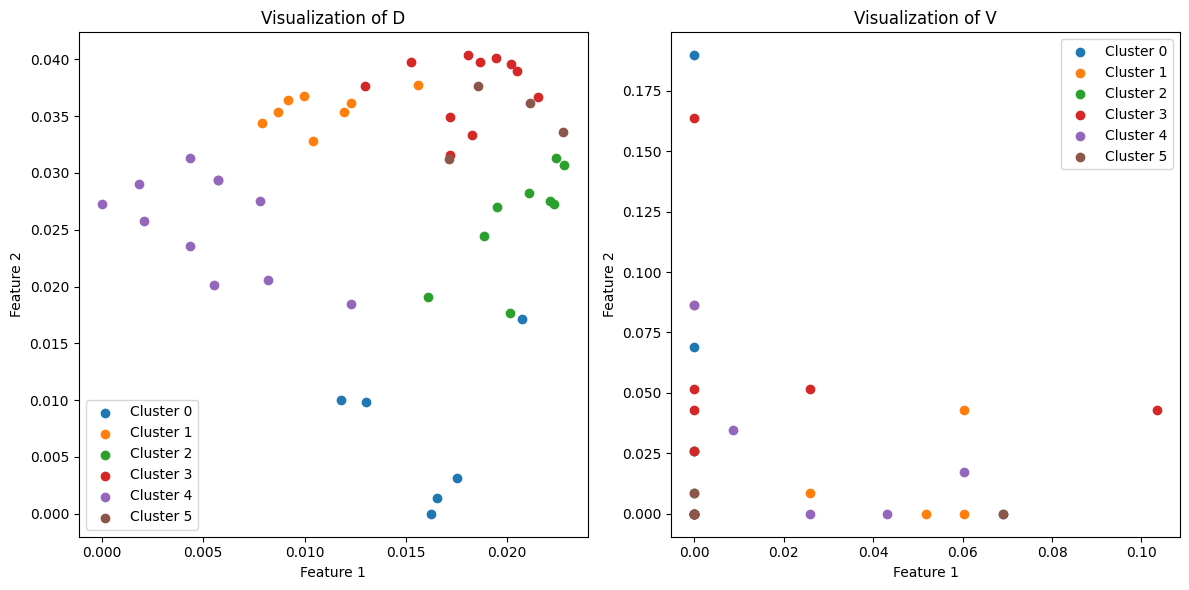

In [119]:
cluster_by_countries(vote_matrix_norm, distance_matrix_norm, num_clusters=2)
cluster_by_countries(vote_matrix_norm, distance_matrix_norm, num_clusters=3)
cluster_by_countries(vote_matrix_norm, distance_matrix_norm, num_clusters=4)
cluster_by_countries(vote_matrix_norm, distance_matrix_norm, num_clusters=5)
cluster_by_countries(vote_matrix_norm, distance_matrix_norm, num_clusters=6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def cluster_by_country_pairs(V, D, num_clusters):
    """
    Perform k-means clustering on the elements of D (country-country pair) and visualize D and V based on clustering results.

    Parameters:
        V (list of list of floats): 2D list with dimensions num*num.
        D (list of list of floats): 2D list with dimensions num*num.
        num_clusters (int): Number of clusters for k-means.

    Returns:
        None
    """
    # Convert inputs to numpy arrays
    V = np.array(V)
    D = np.array(D)

    # Flatten the matrices into 1D arrays for clustering
    D_flat = D.flatten().reshape(-1, 1)
    V_flat = V.flatten().reshape(-1, 1)

    # Perform k-means clustering on the elements of D
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(D_flat)

    # Reshape labels back into the original matrix shape
    labels_matrix = labels.reshape(D.shape)

    # Visualize D
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(labels_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Cluster')
    plt.title('Clustering Visualization of D')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    # Visualize V based on the same labels
    V_clustered = np.zeros_like(V, dtype=float)
    for cluster in range(num_clusters):
        V_clustered[labels_matrix == cluster] = V[labels_matrix == cluster]

    plt.subplot(1, 2, 2)
    plt.imshow(V_clustered, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Visualization of V based on D Clusters')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    plt.tight_layout()
    plt.show()

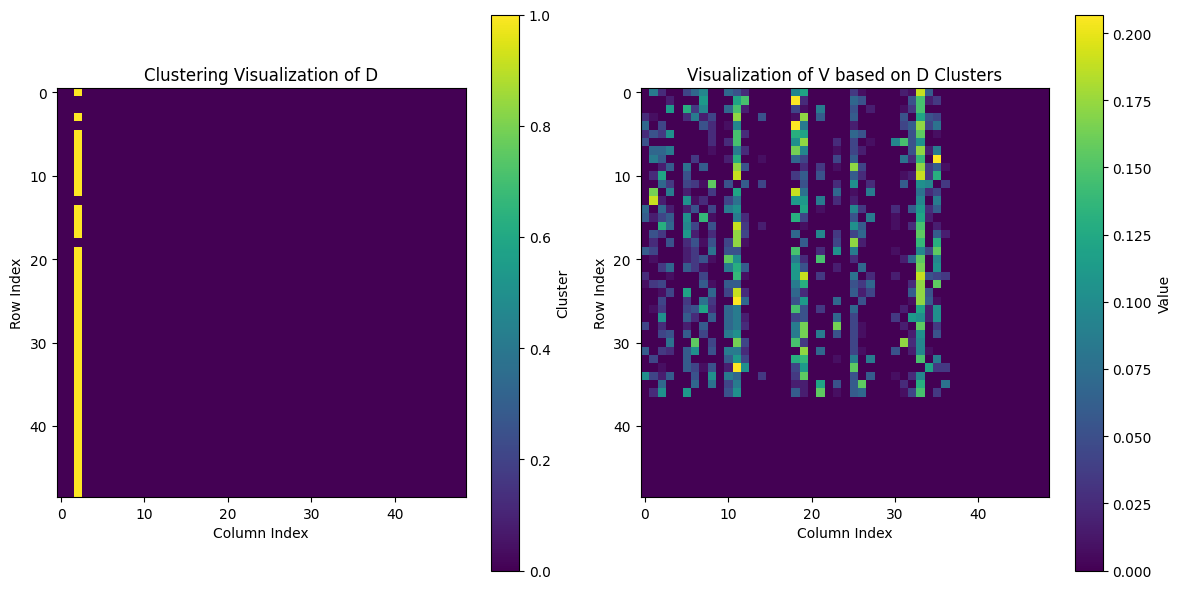

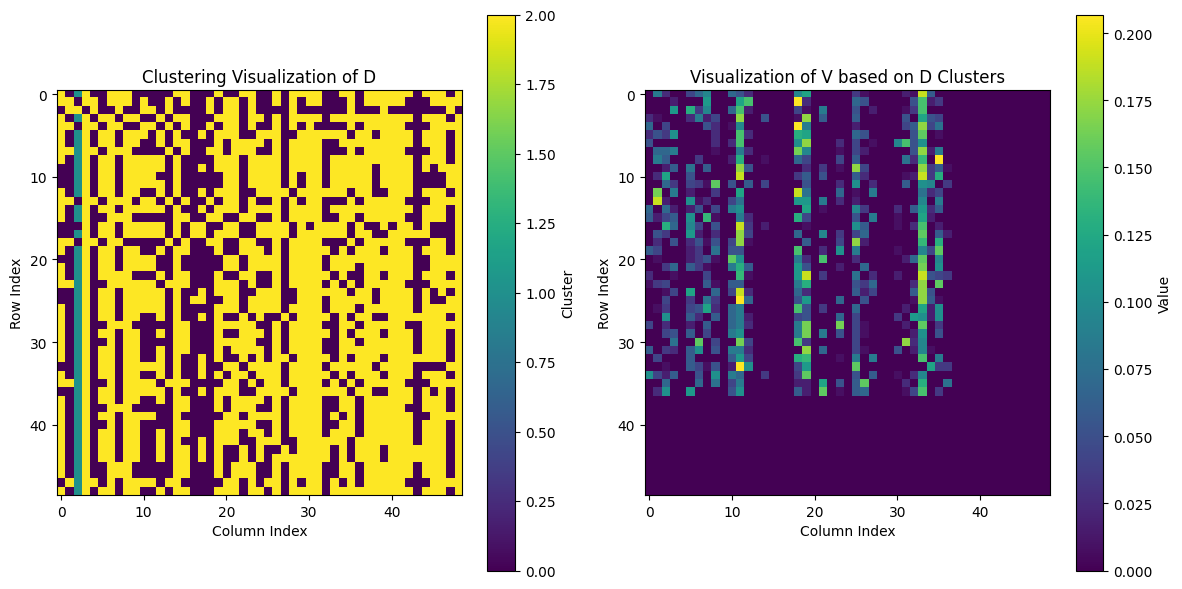

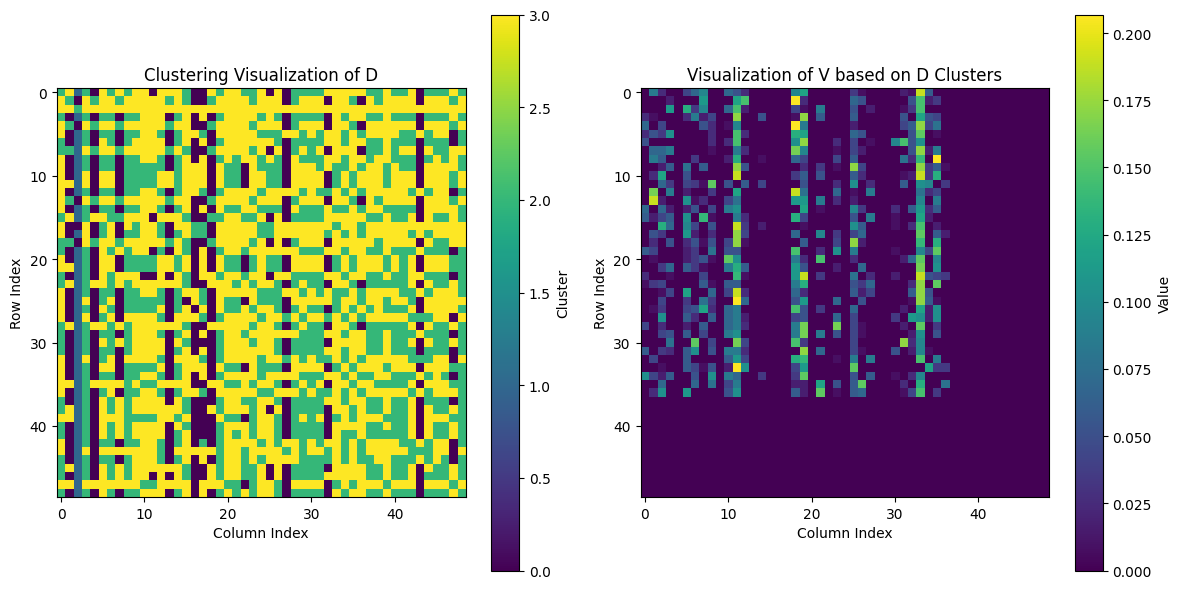

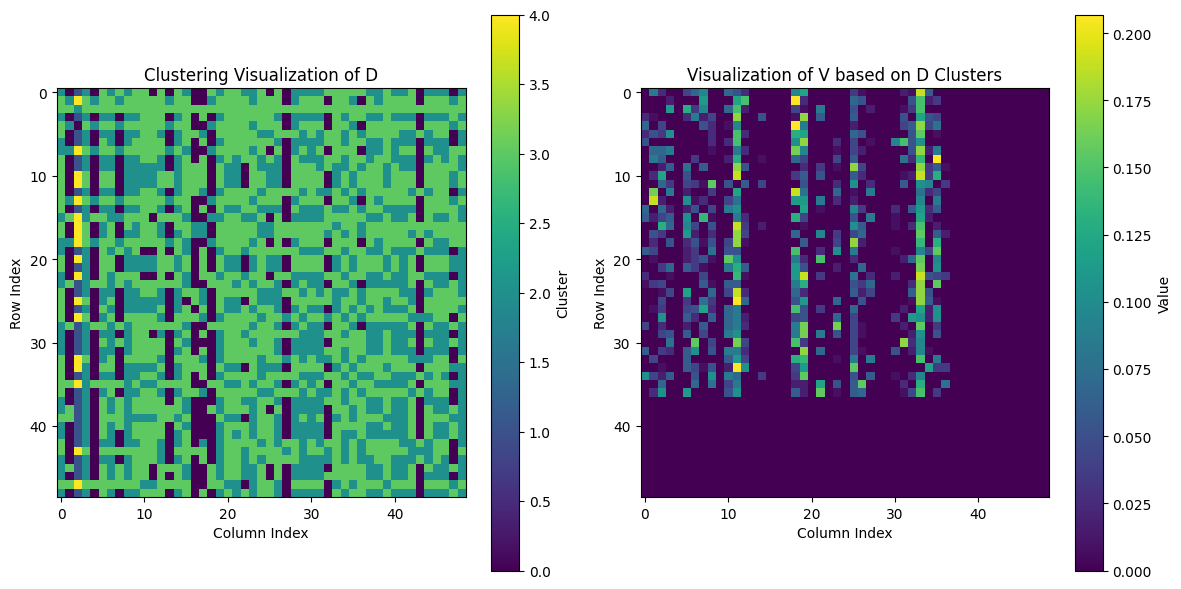

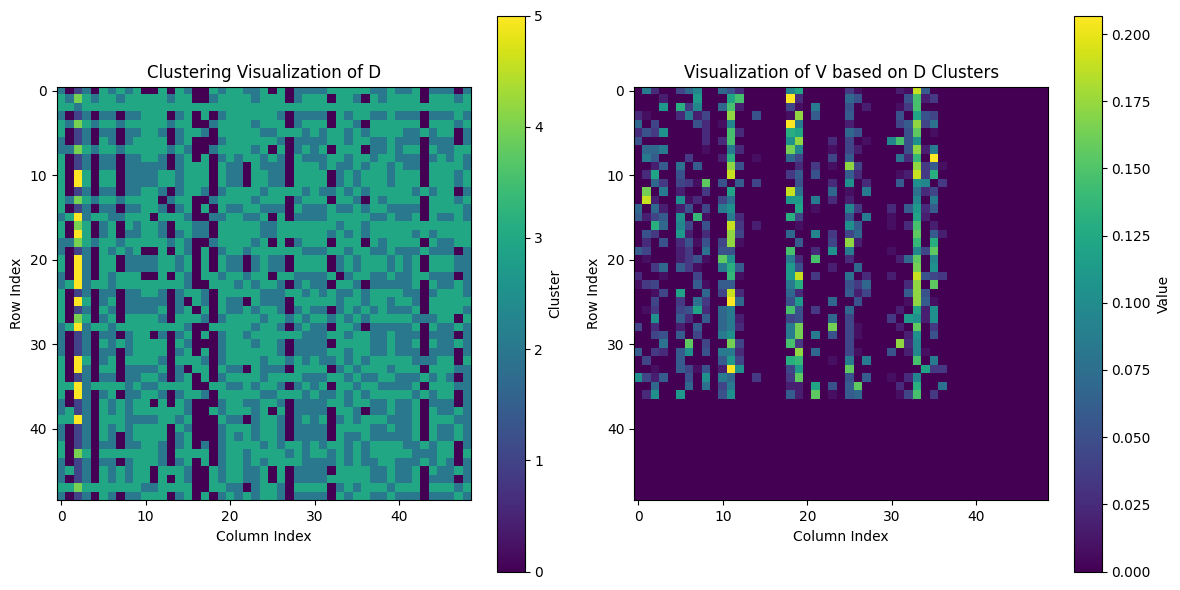

In [123]:
cluster_by_country_pairs(vote_matrix_norm, distance_matrix_norm, num_clusters=2)
cluster_by_country_pairs(vote_matrix_norm, distance_matrix_norm, num_clusters=3)
cluster_by_country_pairs(vote_matrix_norm, distance_matrix_norm, num_clusters=4)
cluster_by_country_pairs(vote_matrix_norm, distance_matrix_norm, num_clusters=5)
cluster_by_country_pairs(vote_matrix_norm, distance_matrix_norm, num_clusters=6)